# 0.0. BUSINESS PROBLEM

## 0.1. Challenge

Find who are most valuable customers to be part of "Insiders" group program. 

## 0.2. Business Questions

1. Who are the customers elegible to participate of Insiders group?
2. How many customers will be part of the group?
3. What are main characteristics of these customers?
4. What is the revenue participation percentaga from Insiders group?
5. What is the expected revenue for the next few months from Insiders group?
6. What conditions a customer must meet to be an Insider?
7. What condisions a customer must meet to be excluded from Insiders group?
8. How to ensure that Insiders group is better than the rest of the customer base?
9. What can Marketing do to increase revenue?

# 1.0. FUNCTIONS & LIBS

## 1.1. Imports

In [102]:
import re
import datetime
import optuna

import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer

from plotly        import express       as px
from sklearn       import cluster       as C
from sklearn       import metrics       as M
from sklearn       import mixture       as mx
from sklearn       import manifold      as mn
from sklearn       import ensemble      as en
from sklearn       import decomposition as dc
from sklearn       import preprocessing as pp
from matplotlib    import pyplot        as plt
from scipy.cluster import hierarchy     as hc

## 1.2. Helper Functions

In [142]:
pd.options.mode.chained_assignment = None

# Defining an objective function to be optimized
def bayesian_opt_objective(trial):
    eps = trial.suggest_float('eps', 0.30, 0.40, step=0.005)
    min_samples = trial.suggest_int('min_samples', 5, 50, step=5)

    # Defining the model
    dbscan_model = C.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

    # Training the model and predicting
    labels = dbscan_model.fit_predict(X)

    # Performance
    sil = M.silhouette_score(X, labels, metric='euclidean')

    return sil 

# 2.0. DATA DESCRIPTION

## 2.1. Variables

**Invoice Number** - unique identifier of each transaction

**Stock Code Product** - item code

**Description Product** - item name

**Quantity** - quantity of each item from a transaction

**Invoice Date** - transaction day

**Unit Price** - item price

**Customer ID** - unque customer identifier

**Country** - country where customer lives

## 2.2. Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='iso-8859-1')
df_raw = df_raw.drop(columns = 'Unnamed: 8')

## 2.3. Rename Columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df_raw.columns = cols_new

## 2.4. DF Dimensions

In [5]:
print('Number of rows: {}'.format(df_raw.shape[0]))
print('Number of columns: {}'.format(df_raw.shape[1]))

Number of rows: 541909
Number of columns: 8


## 2.5. Check NA and Duplicates

In [6]:
# check NA
print('Number of NAs:')
print(df_raw.isna().sum())

# check duplicates
print('\nNumber of Duplicated:')
print(df_raw.duplicated().sum())

Number of NAs:
invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

Number of Duplicated:
5269


In [7]:
# df_raw[df_raw.duplicated(keep=False)].sort_values(by=['customer_id','invoice_no', 'stock_code']).tail(15)
# # after investigating duplicated rows, it was decided to consider them as authentic transactions

### 2.5.1. Replace NA

In [8]:
# first cycle, remove all NA without further analysis
# make a new dataframe
df_raw_1 = df_raw.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format((1-(df_raw_1.shape[0]/df_raw.shape[0]))*100))

# # check NA
# print('Number of NAs:')
# print(df_raw_1.isna().sum())

Removed data: 24.93%


## 2.6. Check DTypes

In [9]:
df_raw_1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 2.6.1 Change DTypes

In [10]:
df_raw_1 = df_raw_1.astype({'customer_id': 'int64'})
df_raw_1['invoice_date'] = pd.to_datetime(df_raw_1['invoice_date'], format='%d-%b-%y')

In [11]:
df_raw_1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 2.7. Descriptive Analysis

In [12]:
num_attributes = df_raw_1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_raw_1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

In [13]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate results
df_num_att = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T. reset_index()
df_num_att.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [14]:
df_num_att

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


In [15]:
# need further investigations: unit_price = 0, and quantity < 0

### 2.7.2. Pandas Profiling

In [16]:
# pd_profile = ProfileReport(df_raw_1)
# pd_profile.to_file('output_df_raw_1.html')

# 3.0. DATA FILTERING

In [17]:
df_raw_3 = df_raw_1.copy()

## 3.1. Data Filtering Analysis

### 3.1.1. unit_price
filter prices lower than 0.01

In [18]:
# investigating prices = 0
df_raw_3[df_raw_3['unit_price']==0].sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2017-03-21,0.0,13239,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2017-01-11,0.0,15107,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2017-04-02,0.0,14410,United Kingdom
314747,564651,22955,36 FOIL STAR CAKE CASES,144,2017-08-24,0.0,14646,Netherlands
436961,574252,M,Manual,1,2017-11-01,0.0,12437,France


In [19]:
# investiating prices = 0.001
df_raw_3[df_raw_3['unit_price']==0.04]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
217060,555876,16045,POPART WOODEN PENCILS ASST,100,2017-06-05,0.04,15799,United Kingdom
221726,556267,16045,POPART WOODEN PENCILS ASST,500,2017-06-07,0.04,13694,United Kingdom
228959,557006,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,14282,United Kingdom
229052,557009,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,14321,United Kingdom
229499,557057,16045,POPART WOODEN PENCILS ASST,100,2017-06-14,0.04,16843,United Kingdom
...,...,...,...,...,...,...,...,...
492556,578126,16045,POPART WOODEN PENCILS ASST,100,2017-11-21,0.04,16900,United Kingdom
506043,579124,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.04,15721,United Kingdom
506918,579161,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.04,17379,United Kingdom
523461,580513,16045,POPART WOODEN PENCILS ASST,100,2017-12-02,0.04,14456,United Kingdom


In [20]:
# investigating prices too high
df_raw_3[df_raw_3['unit_price']>500].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
429588,573576,DOT,DOTCOM POSTAGE,1,2017-10-29,901.58,14096,United Kingdom
387526,C570301,M,Manual,-1,2017-10-08,682.05,16900,United Kingdom
187584,552980,POST,POSTAGE,1,2017-05-10,523.00,12590,Germany
144831,C548830,M,Manual,-1,2017-04-02,2382.92,12744,Singapore
144829,548820,M,Manual,1,2017-04-02,2053.07,12744,Singapore
297438,562946,M,Manual,1,2017-08-09,2500.00,15581,United Kingdom
494728,578270,DOT,DOTCOM POSTAGE,1,2017-11-21,1270.06,14096,United Kingdom
264976,560187,POST,POSTAGE,1,2017-07-13,550.94,17444,Canada
145832,C548914,M,Manual,-1,2017-04-03,1136.30,12669,France
422375,C573079,M,Manual,-2,2017-10-25,4161.06,12536,France


### 3.1.2. quantity
- All invoices with string in the description have negative quantity. It will be considered as returns
- There some high suspect high quantities, however doesn't seem to be errors

In [21]:
# check samples
df_raw_3[df_raw_3['quantity']<0].sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
33630,C539278,22617,BAKING SET SPACEBOY DESIGN,-6,2016-12-14,4.95,18269,United Kingdom
110144,C545673,22808,SET OF 6 T-LIGHTS EASTER CHICKS,-18,2017-03-04,2.95,14745,United Kingdom
446377,C574894,22553,PLASTERS IN TIN SKULLS,-12,2017-11-05,1.65,12597,Spain
296488,C562910,23187,FRENCH STYLE STORAGE JAR BONBONS,-16,2017-08-08,0.29,15671,United Kingdom
439018,C574350,23222,CHRISTMAS TREE HANGING GOLD,-12,2017-11-02,0.83,16637,United Kingdom


In [22]:
# investiganting if invoice_no has any relation with negative values
df_invoice_str = df_raw_3.loc[df_raw_3['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]

# df_invoice_str[df_invoice_str['quantity']>=0]
# df_aux = df_raw_3[df_raw_3['quantity']>0]
# df_aux = df_aux.astype({'invoice_no':'int64'})

In [23]:
# # investigating extreme values
# df_raw_3[df_raw_3['quantity']==12540]

In [24]:
# df_raw_3[(df_raw_3['customer_id']==13256)].sort_values('quantity')

### 3.1.3. stock_code
Exclude stock_codes = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES'] (do not seem to be relevant to the model

In [25]:
df_raw_3.loc[df_raw_3['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
# POST - seems to be cost of exportation to another coutry
# D - discount
# M - seems to be some kind of manual adjustment
# PADS - seems to be some kind of protection that goes in the package
# DOTCOM - ??
# CRUK - ??

# list created using libreoffice calc
exclude_stock_codes = [
'AMAZONFEE',
'B',
'BANK CHARGES',
'C2',
'CRUK',
'D',
'DCGS0003',
'DCGS0004',
'DCGS0055',
'DCGS0057',
'DCGS0066P',
'DCGS0067',
'DCGS0068',
'DCGS0069',
'DCGS0070',
'DCGS0071',
'DCGS0072',
'DCGS0073',
'DCGS0074',
'DCGS0076',
'DCGSSBOY',
'DCGSSGIRL',
'DOT',
'gift_0001_10',
'gift_0001_20',
'gift_0001_30',
'gift_0001_40',
'gift_0001_50',
'M',
'm',
'PADS',
'POST',
'S']

### 3.1.4. country
Do not remove yet

In [26]:
df_raw_3['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [27]:
df_raw_3['country'].value_counts(normalize=True).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [28]:
df_raw_3[df_raw_3['country']=='European Community']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
168149,551013,22839,3 TIER CAKE TIN GREEN AND CREAM,1,2017-04-24,14.95,15108,European Community
168150,551013,22840,ROUND CAKE TIN VINTAGE RED,2,2017-04-24,7.95,15108,European Community
168151,551013,22841,ROUND CAKE TIN VINTAGE GREEN,2,2017-04-24,7.95,15108,European Community
168152,551013,22457,NATURAL SLATE HEART CHALKBOARD,6,2017-04-24,2.95,15108,European Community
168153,551013,22314,OFFICE MUG WARMER CHOC+BLUE,6,2017-04-24,2.95,15108,European Community
...,...,...,...,...,...,...,...,...
273232,560783,21098,CHRISTMAS TOILET ROLL,12,2017-07-19,1.25,15108,European Community
273233,560783,72807C,SET/3 VANILLA SCENTED CANDLE IN BOX,12,2017-07-19,4.25,15108,European Community
273234,560783,85036B,CHOCOLATE 1 WICK MORRIS BOX CANDLE,12,2017-07-19,4.25,15108,European Community
273235,560783,85035C,ROSE 3 WICK MORRIS BOX CANDLE,8,2017-07-19,4.25,15108,European Community


## 3.2. Data Filtering

In [29]:
# unit price
df_raw_3 = df_raw_3.loc[df_raw_3['unit_price']>0.01,:]

# stock code
df_raw_3 = df_raw_3[~df_raw_3['stock_code'].isin(exclude_stock_codes)]

# quantity
df_raw_returns = df_raw_3.loc[df_raw_3['quantity']<0, :]
df_raw_purchases = df_raw_3.loc[df_raw_3['quantity']>=0, :]

# 4.0. FEATURE ENGINEERING

In [30]:
df_raw_4 = df_raw_3.copy()

## 4.1. Features Creation

In [31]:
# separate unique customers
df_ref = df_raw_4.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 4.1.1. Gross Revenue - total money spent by customer

In [32]:
# calculated from total invoices (returns are subtracted from gross revenue)
df_raw_4['gross_revenue'] = df_raw_4['quantity']*df_raw_4['unit_price']
df_gross_revenue = df_raw_4[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_gross_revenue, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

### 4.1.2. Average Ticket Value - average amount of money spent by customer on each transaction

In [33]:
df_avg_ticket = (df_raw_4[['customer_id', 'invoice_no', 'gross_revenue']].groupby('customer_id')
                                                                         .agg(n_invoices=('invoice_no', 'nunique'),
                                                                              sum_revenue=('gross_revenue', 'sum'))
                                                                         .reset_index())
df_avg_ticket['avg_ticket'] = df_avg_ticket['sum_revenue']/df_avg_ticket['n_invoices']
df_ref = pd.merge(df_ref, df_avg_ticket[['customer_id', 'avg_ticket']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
avg_ticket       0
dtype: int64

### 4.1.3. Recency - number of days since last purchase

In [34]:
# recency - last day of purchase
# calculated from dataframe with only purchases
df_recency = df_raw_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency'] = (df_raw_4['invoice_date'].max()-df_recency['invoice_date']).dt.days+1
df_recency = df_recency[['customer_id', 'recency']]
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue     0
avg_ticket        0
recency          28
dtype: int64

### 4.1.4. Frequency - number of purchases in last 365 days

In [35]:
# frequency - number of purchases in last 365 days
dd = datetime.timedelta(days=365)
df_frequency = df_raw_purchases[df_raw_purchases['invoice_date']>=(df_raw_purchases['invoice_date'].max() - dd)][['invoice_no', 'customer_id']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'frequency'})
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue     0
avg_ticket        0
recency          28
frequency        91
dtype: int64

### 4.1.5. Quantity of Returns - number of invoices with negative quantity

In [36]:
df_returns = (df_raw_returns[['customer_id', 'invoice_no']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .count()
                                                           .reset_index()
                                                           .rename(columns={'invoice_no':'qty_returns'}))
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue       0
avg_ticket          0
recency            28
frequency          91
qty_returns      2828
dtype: int64

### 4.1.6. Amount Returned

In [37]:
df_raw_returns['amount_returned'] = df_raw_returns['quantity']*df_raw_returns['unit_price']*-1
df_amount_returned = df_raw_returns[['customer_id', 'amount_returned']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_amount_returned, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              28
frequency            91
qty_returns        2828
amount_returned    2828
dtype: int64

### 4.1.7. Quantity of Products

In [38]:
df_quantity = (df_raw_4[['customer_id','quantity']].groupby('customer_id')
                                                           .sum()
                                                           .reset_index()
                                                           .rename(columns={'quantity': 'qty_items'}))
df_ref = pd.merge(df_ref, df_quantity, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              28
frequency            91
qty_returns        2828
amount_returned    2828
qty_items             0
dtype: int64

### 4.1.8. Average Basket Size - quantity of products / total of invoices

In [39]:
df_avg_bs = (df_raw_4[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchases=('invoice_no', 'nunique'),
                                                                             n_products=('quantity', 'sum'))
                                                                        .reset_index())
df_avg_bs['avg_basket_size'] = df_avg_bs['n_products']/df_avg_bs['n_purchases']
df_ref = pd.merge(df_ref, df_avg_bs[['customer_id', 'avg_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              28
frequency            91
qty_returns        2828
amount_returned    2828
qty_items             0
avg_basket_size       0
dtype: int64

### 4.1.9. Assortment- quantity of distinct items purchased

In [40]:
df_assortment = (df_raw_purchases[['customer_id', 'stock_code']].drop_duplicates()
                                                                .groupby('customer_id')
                                                                .count()
                                                                .reset_index()
                                                                .rename(columns={'stock_code': 'assortment'}))
df_ref = pd.merge(df_ref, df_assortment, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              28
frequency            91
qty_returns        2828
amount_returned    2828
qty_items             0
avg_basket_size       0
assortment           28
dtype: int64

## 4.2. Check NA and DTypes after Feature Creation

In [41]:
# NANs
df_ref.isna().sum()

customer_id           0
gross_revenue         0
avg_ticket            0
recency              28
frequency            91
qty_returns        2828
amount_returned    2828
qty_items             0
avg_basket_size       0
assortment           28
dtype: int64

In [42]:
# DTypes
df_ref.dtypes

customer_id          int64
gross_revenue      float64
avg_ticket         float64
recency            float64
frequency          float64
qty_returns        float64
amount_returned    float64
qty_items            int64
avg_basket_size    float64
assortment         float64
dtype: object

### 4.2.1. Replace NA in df_ref

In [43]:
# nan values were assigned to customers with 0 purchases in the last 365 days
df_ref['frequency'] = df_ref['frequency'].fillna(0)

# nan values were assigned to customers wih 0 returns
df_ref['qty_returns'] = df_ref['qty_returns'].fillna(0)
df_ref['amount_returned'] = df_ref['amount_returned'].fillna(0)

# drop NA for remaining attributes
df_ref = df_ref.dropna()

In [44]:
# change dtypes
df_ref = df_ref.astype({'recency':'int64', 
                        'frequency': 'int64', 
                        'qty_returns':'int64',
                        'qty_items': 'int64',
                        'assortment':'int64'})

# 5.0. EDA (EXPLORATORY DATA ANALYSIS)

In [45]:
df_ref_5 = df_ref.copy()

## 5.1. Univariate Analysis

In [46]:
# pd_profile = ProfileReport(df_ref_5)
# pd_profile.to_file('output_df_ref_5_02R.html')

### 5.1.1. Gross Revenue
- OK

In [47]:
df_ref_5[df_ref_5['gross_revenue']>180000]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
401,17450,189735.53,3872.153673,9,44,3,4815.26,69041,1409.000000,124
448,18102,259657.30,4327.621667,1,57,0,0.00,64124,1068.733333,150
907,14646,278778.02,3818.876986,2,72,1,360.00,196556,2692.547945,699


In [48]:
df_raw_4[df_raw_4['customer_id']==18102].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
411202,572196,82583,HOT BATHS METAL SIGN,432,2017-10-19,1.49,18102,United Kingdom,643.68
343138,566934,48138,DOORMAT UNION FLAG,500,2017-09-13,4.58,18102,United Kingdom,2290.00
373804,569362,23543,KEEP CALM WALL ART,24,2017-10-01,6.98,18102,United Kingdom,167.52
217191,555920,48194,DOORMAT HEARTS,200,2017-06-05,4.58,18102,United Kingdom,916.00
191465,553368,23284,DOORMAT KEEP CALM AND COME IN,200,2017-05-14,4.58,18102,United Kingdom,916.00
373809,569362,23525,WALL ART BUFFALO BILL,120,2017-10-01,2.66,18102,United Kingdom,319.20
217185,555920,48173C,DOORMAT BLACK FLOCK,200,2017-06-05,4.58,18102,United Kingdom,916.00
191450,553368,21523,DOORMAT FANCY FONT HOME SWEET HOME,100,2017-05-14,4.58,18102,United Kingdom,458.00
343131,566933,22365,DOORMAT RESPECTABLE HOUSE,20,2017-09-13,4.58,18102,United Kingdom,91.60
373671,569343,23543,KEEP CALM WALL ART,180,2017-10-01,7.45,18102,United Kingdom,1341.00


### 5.1.2. Average Ticket
- OK

In [49]:
df_ref_5[df_ref_5['avg_ticket']>5000]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
978,12415,123638.18,5151.590833,25,20,4,926.35,76946,3206.083333,443
1075,15749,21535.90,5383.975000,236,3,1,22998.40,9014,2253.500000,5
2848,15098,39619.50,9904.875000,183,3,1,297.00,61,15.250000,1
4072,12357,6207.67,6207.670000,34,1,0,0.00,2708,2708.000000,131


In [50]:
df_raw_4[df_raw_4['customer_id']==15098]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2017-06-08,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2017-06-08,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2017-06-08,649.50,15098,United Kingdom,649.5
222692,C556448,22502,PICNIC BASKET WICKER SMALL,-60,2017-06-08,4.95,15098,United Kingdom,-297.0


### 5.1.3. Frequency
- OK

In [51]:
df_ref_5[df_ref_5['frequency']>180]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
47,12748,30486.53,140.490922,1,192,11,1830.79,23976,110.488479,1766
66,14911,128882.13,532.570785,2,191,44,7393.59,76848,317.553719,1785


In [52]:
df_raw_4[df_raw_4['customer_id']==14911].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
533651,581098,22465,HANGING METAL STAR LANTERN,12,2017-12-05,0.79,14911,EIRE,9.48
71851,542216,22714,CARD BIRTHDAY COWBOY,12,2017-01-24,0.42,14911,EIRE,5.04
64761,541670,22424,ENAMEL BREAD BIN CREAM,8,2017-01-18,10.95,14911,EIRE,87.60
195032,553686,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,48,2017-05-16,1.25,14911,EIRE,60.00
457005,575728,21224,SET/4 SKULL BADGES,10,2017-11-08,1.25,14911,EIRE,12.50
119007,546520,21792,CLASSIC FRENCH STYLE BASKET GREEN,4,2017-03-12,6.75,14911,EIRE,27.00
364274,568654,21253,SET OF PICTURE FRAME STICKERS,12,2017-09-26,2.95,14911,EIRE,35.40
216927,555858,22908,PACK OF 20 NAPKINS RED APPLES,12,2017-06-05,0.85,14911,EIRE,10.20
410705,572127,20893,HANGING BAUBLE T-LIGHT HOLDER SMALL,6,2017-10-19,2.55,14911,EIRE,15.30
391675,570674,84032A,CHARLIE+LOLA PINK HOT WATER BOTTLE,6,2017-10-09,2.95,14911,EIRE,17.70


### 5.1.4. Quantity of Returns
- OK

In [53]:
df_ref_5[df_ref_5['qty_returns']>30]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
66,14911,128882.13,532.570785,2,191,44,7393.59,76848,317.553719,1785
68,17841,40333.22,238.658107,2,121,45,634.50,22850,135.207101,1322
92,14606,11567.10,92.536800,2,87,35,439.55,5969,47.752000,816


In [54]:
df_raw_4[df_raw_4['customer_id']==17841].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
393230,570818,22726,ALARM CLOCK BAKELIKE GREEN,1,2017-10-10,3.75,17841,United Kingdom,3.75
230208,557129,21918,SET 12 KIDS COLOUR CHALK STICKS,1,2017-06-14,0.42,17841,United Kingdom,0.42
495009,578289,23393,HOME SWEET HOME CUSHION COVER,9,2017-11-21,3.75,17841,United Kingdom,33.75
458002,575753,23212,HEART WREATH DECORATION WITH BELL,1,2017-11-09,1.25,17841,United Kingdom,1.25
214027,555562,47421,ASSORTED COLOUR LIZARD SUCTION HOOK,8,2017-06-03,0.42,17841,United Kingdom,3.36
365699,568712,21925,UNION STRIPE CUSHION COVER,2,2017-09-26,1.25,17841,United Kingdom,2.50
206555,554942,22432,WATERING CAN PINK BUNNY,1,2017-05-25,1.95,17841,United Kingdom,1.95
360432,568227,21926,RED/CREAM STRIPE CUSHION COVER,2,2017-09-24,1.25,17841,United Kingdom,2.50
328326,565766,21216,"SET 3 RETROSPOT TEA,COFFEE,SUGAR",1,2017-09-04,4.95,17841,United Kingdom,4.95
159763,550359,22468,BABUSHKA LIGHTS STRING OF 10,1,2017-04-16,6.75,17841,United Kingdom,6.75


### 5.1.5. Amount Returned
- OK

In [55]:
df_ref_5[df_ref_5['amount_returned']>50000]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
1168,12346,0.0,0.000000,326,1,1,77183.6,0,0.000000,1
2647,16446,2.9,0.966667,1,2,1,168469.6,2,0.666667,3


In [56]:
df_raw_4[df_raw_4['customer_id']==16446]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,16446,United Kingdom,1.65
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,16446,United Kingdom,1.25
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,16446,United Kingdom,168469.60
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,16446,United Kingdom,-168469.60


### 5.1.6. Quantity of Items
- Change method of calculation to sum negative values of returns, so we have qty of items that was sold and not returned - **DONE**
- **OBS**: filter values <= 0

In [57]:
# df_ref_5[df_ref_5['qty_items']>50000].sort_values('qty_items', ascending=False)
df_ref_5[df_ref_5['qty_items']<=0]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
16,17548,-1.414800e+02,-4.716000e+01,234,1,2,244.78,-132,-44.0,5
125,16546,-9.593000e+01,-3.197667e+01,291,1,1,883.08,-303,-101.0,25
1051,13672,0.000000e+00,0.000000e+00,302,2,3,186.39,0,0.0,4
1168,12346,0.000000e+00,0.000000e+00,326,1,1,77183.60,0,0.0,1
2507,13762,3.552714e-15,1.776357e-15,219,1,1,306.72,0,0.0,7
3155,18268,0.000000e+00,0.000000e+00,135,1,1,25.50,0,0.0,1
3470,14557,0.000000e+00,0.000000e+00,86,1,1,788.38,0,0.0,16
3479,16878,0.000000e+00,0.000000e+00,85,1,1,13.30,0,0.0,3
3634,13364,0.000000e+00,0.000000e+00,72,1,1,134.96,0,0.0,10
3717,14792,0.000000e+00,0.000000e+00,64,1,1,6.20,0,0.0,2


In [58]:
df_raw_4[df_raw_4['customer_id']==12558]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
519634,580158,22712,CARD DOLLY GIRL,12,2017-11-30,0.42,12558,USA,5.04
519635,580158,23344,JUMBO BAG 50'S CHRISTMAS,10,2017-11-30,2.08,12558,USA,20.80
519636,580158,85099B,JUMBO BAG RED RETROSPOT,10,2017-11-30,2.08,12558,USA,20.80
519637,580158,23209,LUNCH BAG VINTAGE DOILY,20,2017-11-30,1.65,12558,USA,33.00
519638,580158,79191C,RETRO PLASTIC ELEPHANT TRAY,24,2017-11-30,0.85,12558,USA,20.40
519639,580158,23392,SPACEBOY ROCKET LOLLY MAKERS,24,2017-11-30,2.08,12558,USA,49.92
519640,580158,84828,JUNGLE POPSICLES ICE LOLLY MOULDS,24,2017-11-30,1.25,12558,USA,30.00
519641,580158,23158,SET OF 5 LUCKY CAT MAGNETS,36,2017-11-30,2.08,12558,USA,74.88
519642,580158,21507,ELEPHANT BIRTHDAY CARD,12,2017-11-30,0.42,12558,USA,5.04
519643,580158,21508,VINTAGE KID DOLLY CARD,12,2017-11-30,0.42,12558,USA,5.04


### 5.1.7. Average Basket Size
- Change method of calculation to sum negative values of returns, so we have qty of items that was sold and not returned - **DONE**
- **OBS**: filter values <= 0

In [59]:
# df_ref_5[df_ref_5['avg_basket_size']>5000].sort_values('avg_basket_size', ascending=False)
df_ref_5[df_ref_5['avg_basket_size']<=0]

,customer_id,gross_revenue,avg_ticket,recency,frequency,qty_returns,amount_returned,qty_items,avg_basket_size,assortment
16,17548,-1.414800e+02,-4.716000e+01,234,1,2,244.78,-132,-44.0,5
125,16546,-9.593000e+01,-3.197667e+01,291,1,1,883.08,-303,-101.0,25
1051,13672,0.000000e+00,0.000000e+00,302,2,3,186.39,0,0.0,4
1168,12346,0.000000e+00,0.000000e+00,326,1,1,77183.60,0,0.0,1
2507,13762,3.552714e-15,1.776357e-15,219,1,1,306.72,0,0.0,7
3155,18268,0.000000e+00,0.000000e+00,135,1,1,25.50,0,0.0,1
3470,14557,0.000000e+00,0.000000e+00,86,1,1,788.38,0,0.0,16
3479,16878,0.000000e+00,0.000000e+00,85,1,1,13.30,0,0.0,3
3634,13364,0.000000e+00,0.000000e+00,72,1,1,134.96,0,0.0,10
3717,14792,0.000000e+00,0.000000e+00,64,1,1,6.20,0,0.0,2


In [60]:
df_raw_4[df_raw_4['customer_id']==18251]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
339449,566595,21975,PACK OF 60 DINOSAUR CAKE CASES,600,2017-09-11,0.42,18251,United Kingdom,252.00
339450,566595,21213,PACK OF 72 SKULL CAKE CASES,600,2017-09-11,0.42,18251,United Kingdom,252.00
339451,566595,84992,72 SWEETHEART FAIRY CAKE CASES,600,2017-09-11,0.42,18251,United Kingdom,252.00
339452,566595,84991,60 TEATIME FAIRY CAKE CASES,600,2017-09-11,0.42,18251,United Kingdom,252.00
339453,566595,23340,VINTAGE CHRISTMAS CAKE FRILL,480,2017-09-11,1.45,18251,United Kingdom,696.00
339454,566595,21212,PACK OF 72 RETROSPOT CAKE CASES,600,2017-09-11,0.42,18251,United Kingdom,252.00
339455,566595,21977,PACK OF 60 PINK PAISLEY CAKE CASES,600,2017-09-11,0.42,18251,United Kingdom,252.00
339456,566595,23378,PACK OF 12 50'S CHRISTMAS TISSUES,432,2017-09-11,0.32,18251,United Kingdom,138.24
339457,566595,23380,PACK OF 12 VINTAGE DOILY TISSUES,432,2017-09-11,0.32,18251,United Kingdom,138.24
339458,566595,23381,PACK OF 12 VINTAGE LEAF TISSUES,432,2017-09-11,0.32,18251,United Kingdom,138.24


## 5.2. Bivariate Analysis

In [61]:
df_ref_52 = df_ref_5.drop(columns = 'customer_id')

<Figure size 2500x1200 with 0 Axes>

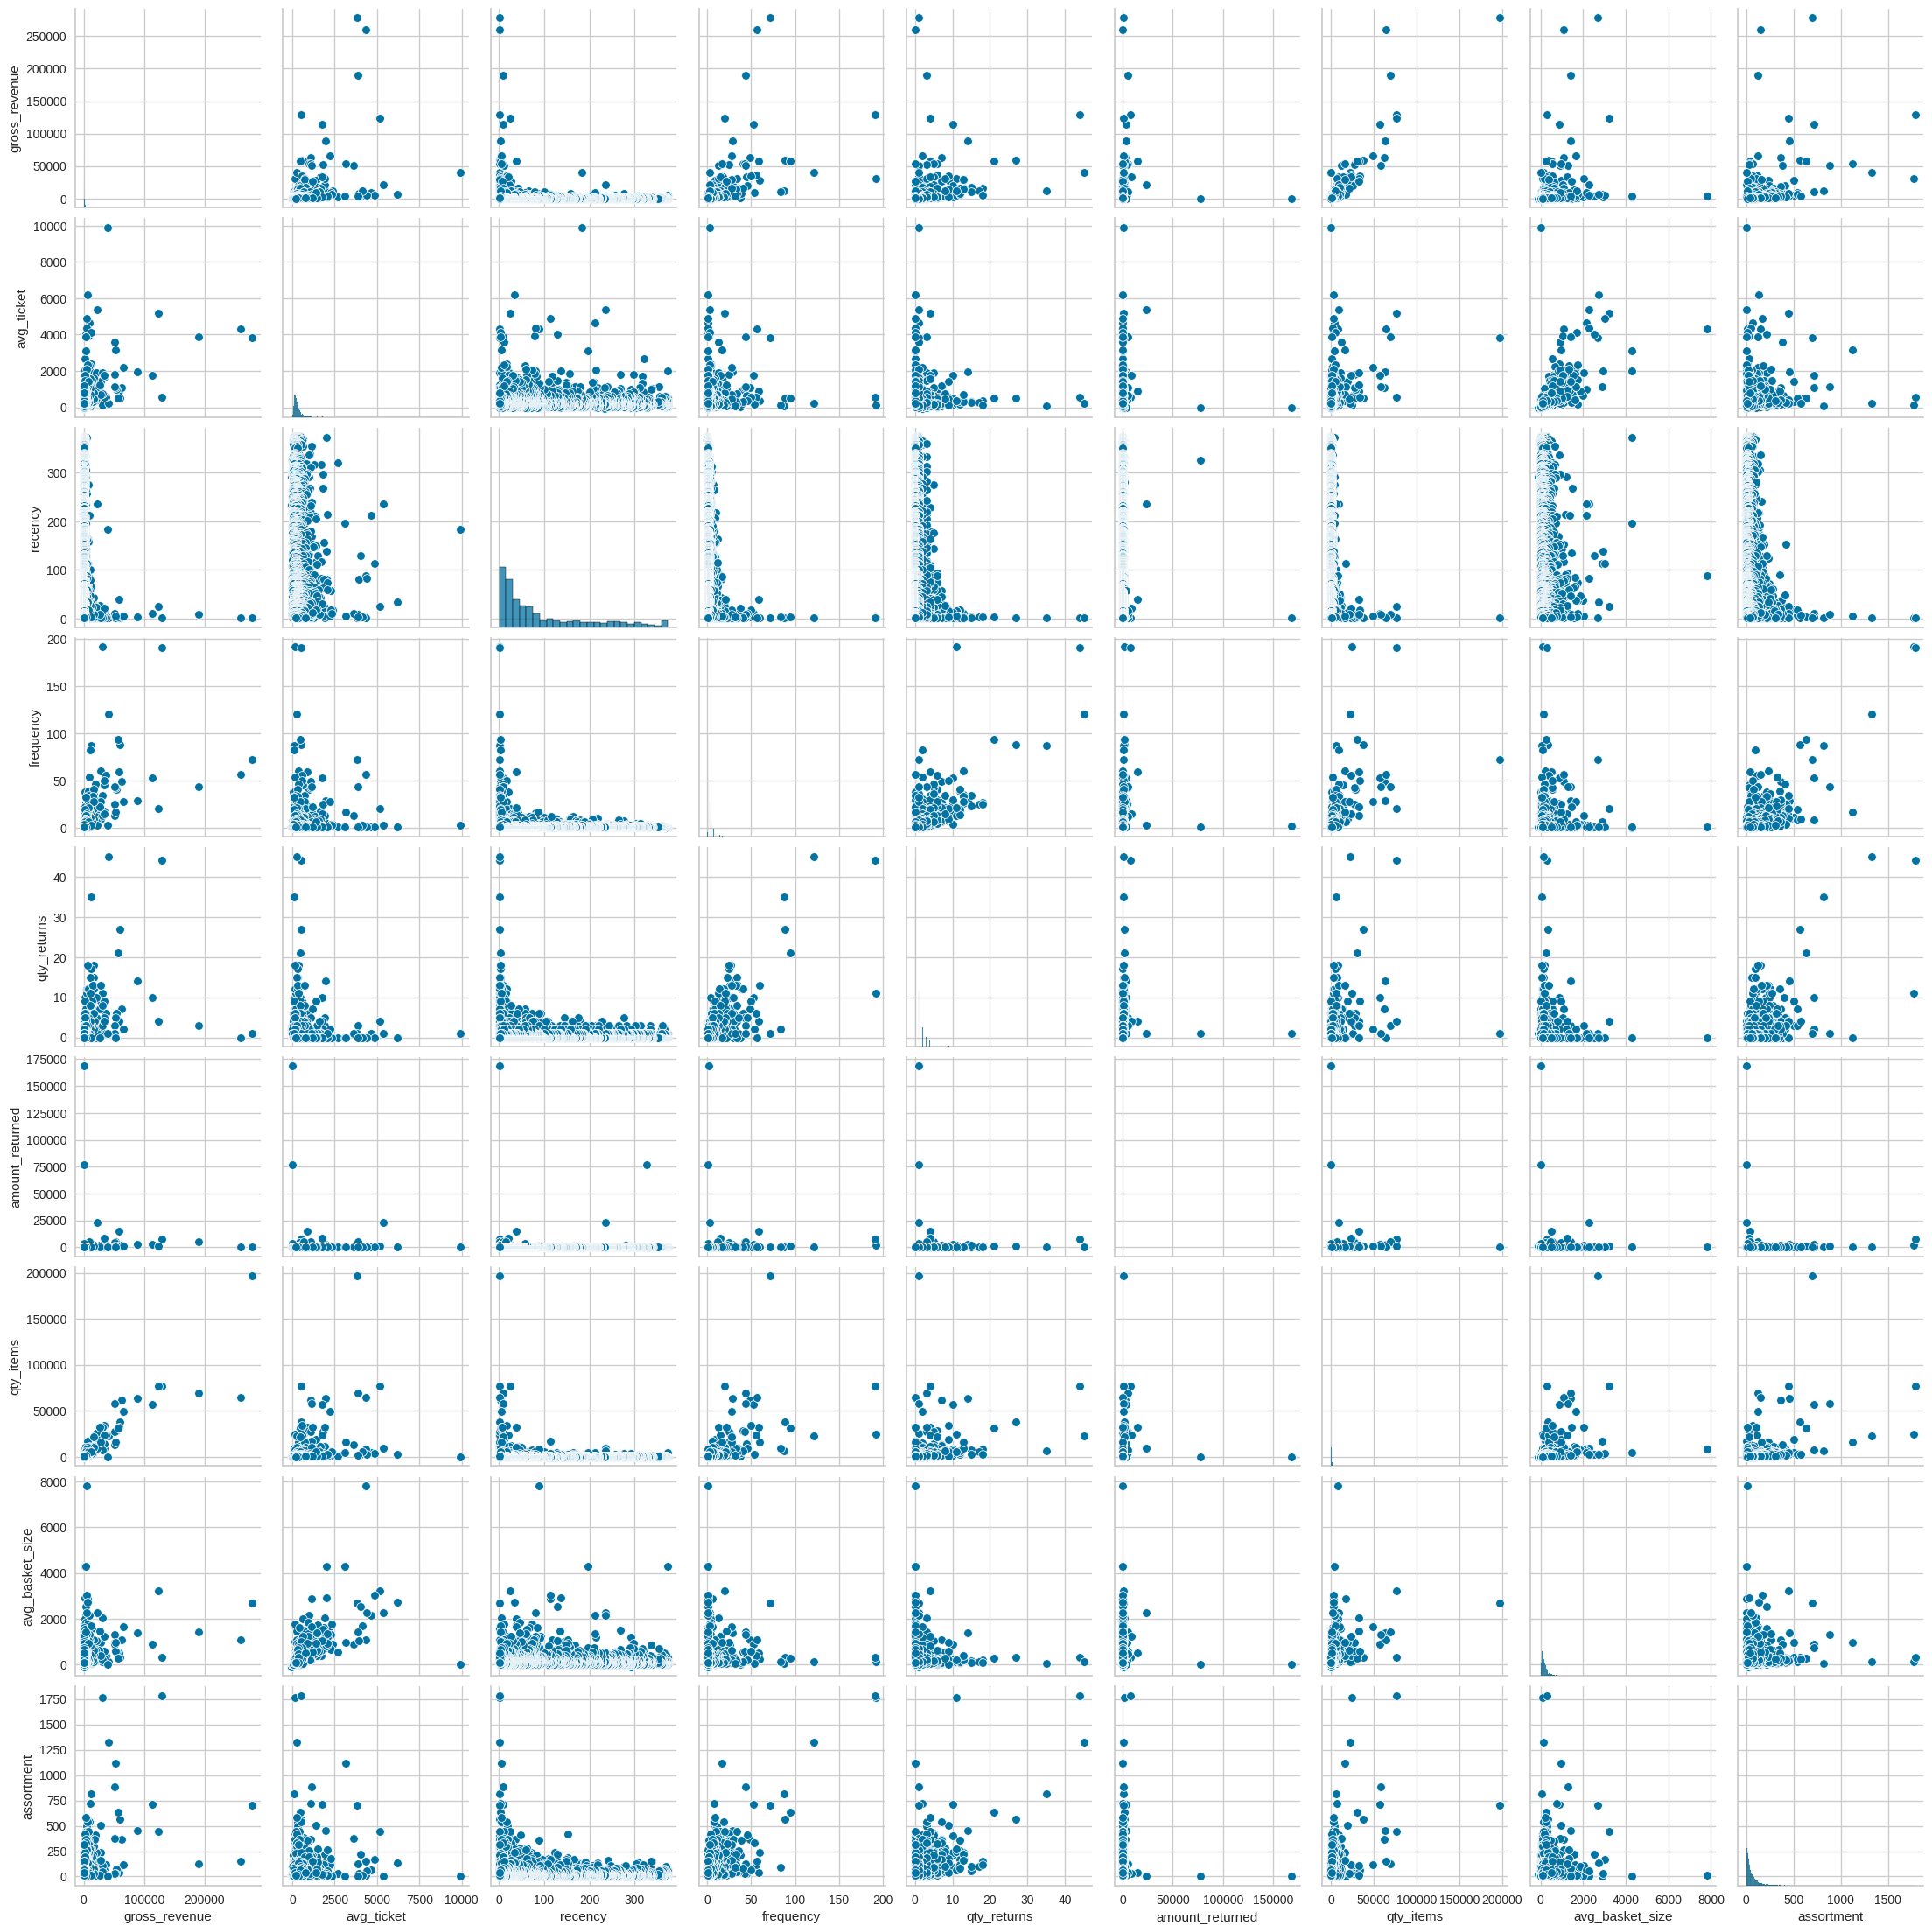

In [62]:
plt.figure(figsize=(25, 12))
sns.pairplot(df_ref_52);

**Notes**
- amount_returned has low variance

## 5.3. Space Analysis

In [63]:
mm = pp.MinMaxScaler()

df_ref_52['gross_revenue']   = mm.fit_transform(df_ref_52[['gross_revenue']])
df_ref_52['avg_ticket']      = mm.fit_transform(df_ref_52[['avg_ticket']])
df_ref_52['recency']         = mm.fit_transform(df_ref_52[['recency']])
df_ref_52['frequency']       = mm.fit_transform(df_ref_52[['frequency']])
df_ref_52['qty_returns']     = mm.fit_transform(df_ref_52[['qty_returns']])
df_ref_52['amount_returned'] = mm.fit_transform(df_ref_52[['amount_returned']])
df_ref_52['qty_items']       = mm.fit_transform(df_ref_52[['qty_items']])
df_ref_52['avg_basket_size'] = mm.fit_transform(df_ref_52[['avg_basket_size']])
df_ref_52['assortment']      = mm.fit_transform(df_ref_52[['assortment']])

X = df_ref_52.copy()

### 5.3.1. PCA

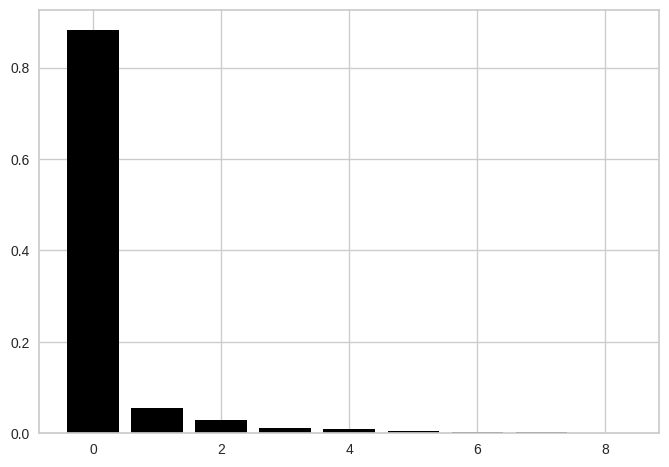

In [67]:
pca = dc.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variables
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')

df_pca = pd.DataFrame(principal_components)

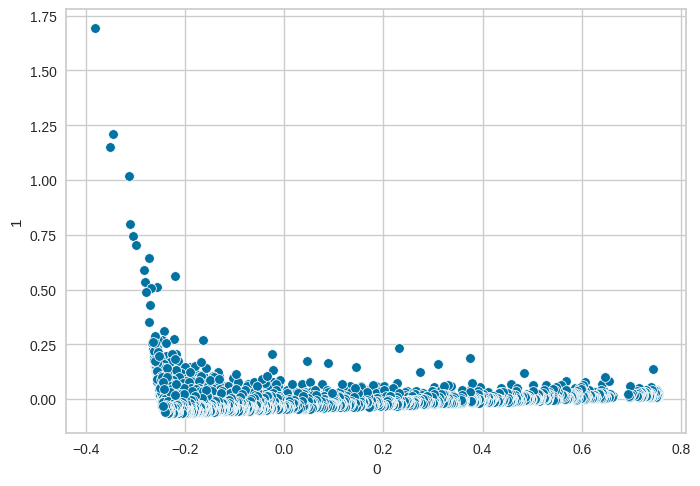

In [68]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 5.3.2. UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

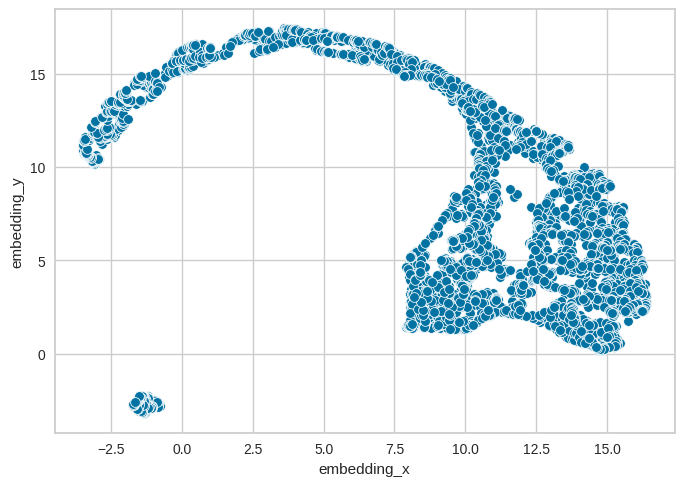

In [69]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 5.3.3. t-SNE

/home/felipe/repos/insiders_clustering/insiders_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/repos/insiders_clustering/insiders_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


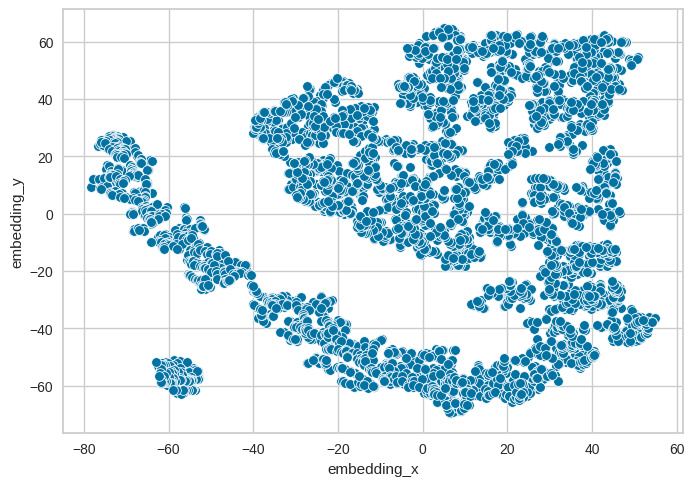

In [70]:
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot t-SNE
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 5.3.4. Tree-Based Embedding

In [71]:
# training dataset
X = df_ref_5.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df_ref_5['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

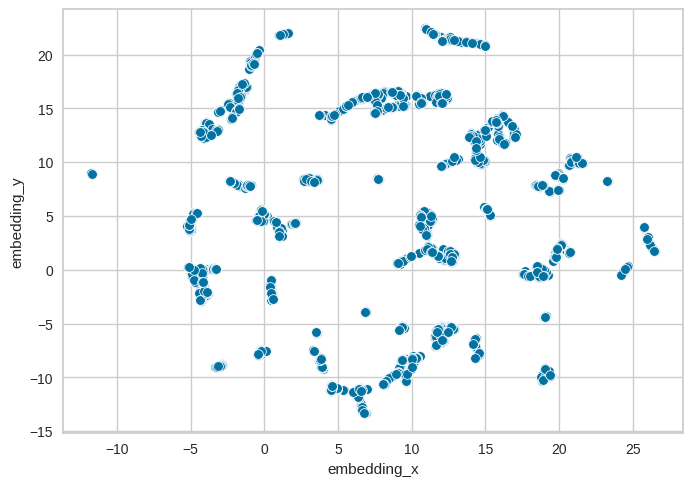

In [72]:
# dataframe leafs
df_leaf = pd.DataFrame(rf_model.apply(X))

# reducer of dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot df_tree
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 6.0. DATA PREPARATION

In [73]:
df_ref_6 = df_ref_5.copy()

In [76]:
ss = pp.MinMaxScaler()

df_ref_6['gross_revenue']   = mm.fit_transform(df_ref_6[['gross_revenue']])
df_ref_6['avg_ticket']      = mm.fit_transform(df_ref_6[['avg_ticket']])
df_ref_6['recency']         = mm.fit_transform(df_ref_6[['recency']])
df_ref_6['frequency']       = mm.fit_transform(df_ref_6[['frequency']])
df_ref_6['qty_returns']     = mm.fit_transform(df_ref_6[['qty_returns']])
df_ref_6['amount_returned'] = mm.fit_transform(df_ref_6[['amount_returned']])
df_ref_6['qty_items']       = mm.fit_transform(df_ref_6[['qty_items']])
df_ref_6['avg_basket_size'] = mm.fit_transform(df_ref_6[['avg_basket_size']])
df_ref_6['assortment']      = mm.fit_transform(df_ref_6[['assortment']])

# 7.0. FEATURE SELECTION

In [77]:
df_ref_7 = df_ref_6.copy()

# 8.0. HYPER-PARAMETER FINE TUNING

In [79]:
X = df_ref_7.drop(columns='customer_id')

In [82]:
# number of cluster to test
clusters = [2, 3, 4, 5, 6, 7, 8]

## 8.1. KMeans

In [86]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = C.KMeans(n_clusters=k)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = M.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhoutte Score x K')

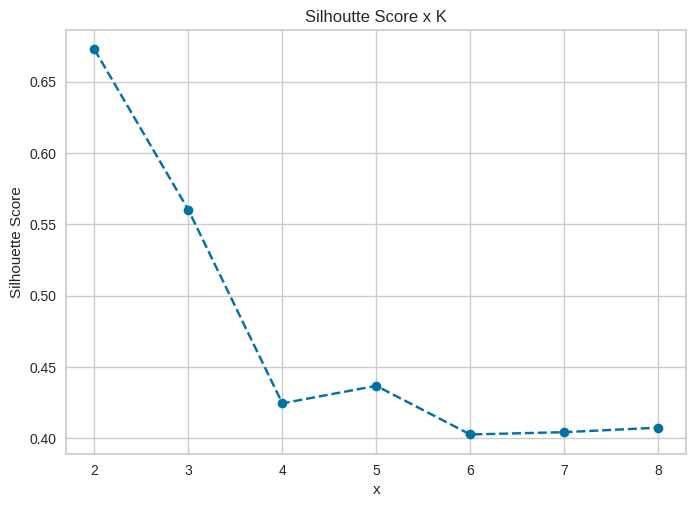

In [87]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('x')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Score x K')

## 8.2. GMM

In [90]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=100)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    sil = M.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'Silhoutte Score x K')

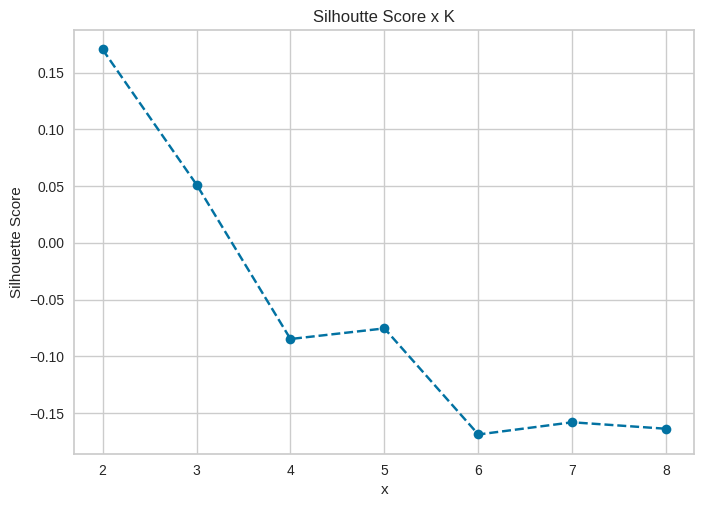

In [91]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('x')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Score x K')

## 8.3. Hierarchical Clustering

### 8.3.1. Dendrogram

In [93]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

[]

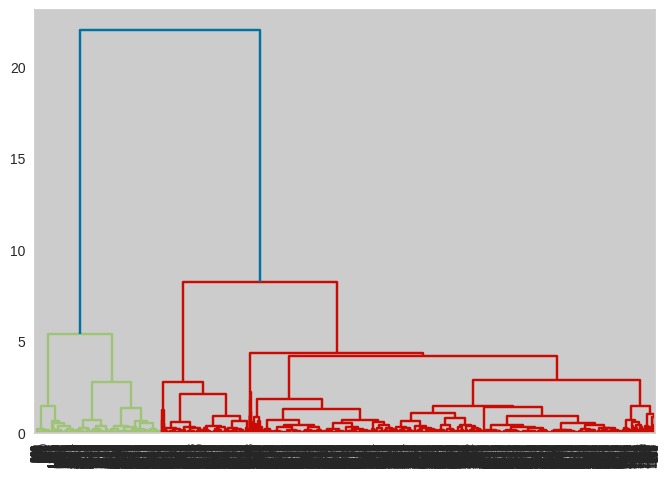

In [95]:
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)
plt.plot()

[]

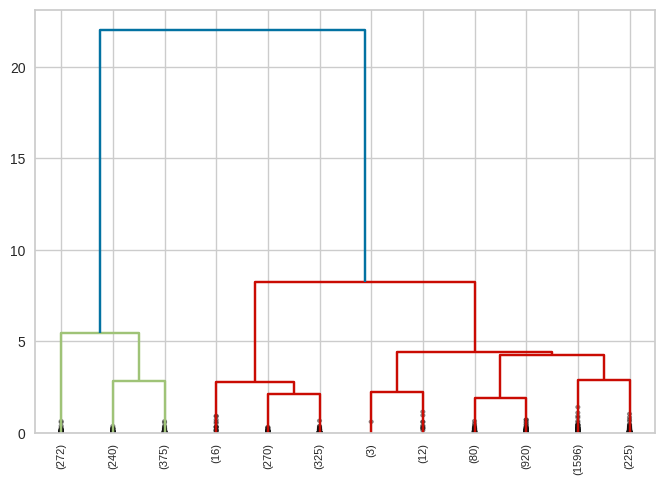

In [96]:
hc.dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
plt.plot()

### 8.3.2. HClustering Silhouette Score

In [97]:
hc_list = []

for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')
    
    # model prediction
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = M.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

Text(0.5, 1.0, 'Silhoutte Score x K')

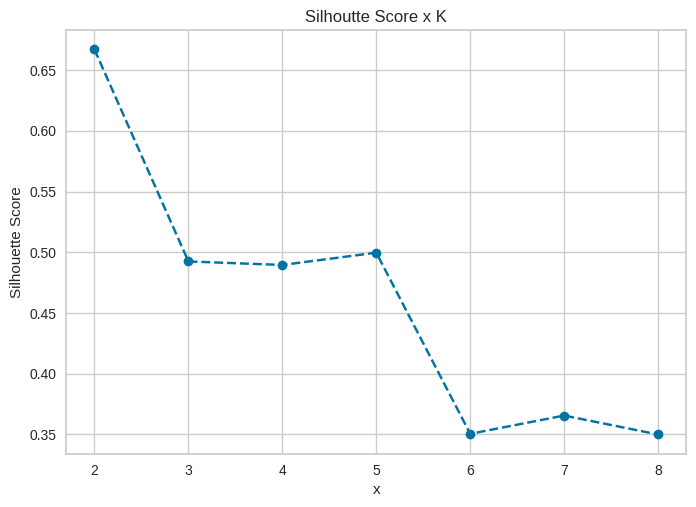

In [98]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('x')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Score x K')

## 8.4. DBSCAN

### 8.4.1. Finding Best Parameters

In [143]:
study = optuna.create_study(direction='maximize') # maximizing the precision at k
study.optimize(bayesian_opt_objective, n_trials=100); # optimizing the defined function and setting the number of trials
trial = study.best_trial

print(f'Best Silhouette Score = {trial.value} with K = {len(set(labels))}')
print(f'Best Hyperparameters = {trial.params}')

[I 2022-11-30 13:36:34,880] A new study created in memory with name: no-name-8246f184-9c90-4452-bcc4-369737897ce8
[I 2022-11-30 13:36:35,527] Trial 0 finished with value: 0.722047316095107 and parameters: {'eps': 0.355, 'min_samples': 20}. Best is trial 0 with value: 0.722047316095107.
[I 2022-11-30 13:36:36,140] Trial 1 finished with value: 0.7212398529143685 and parameters: {'eps': 0.38, 'min_samples': 50}. Best is trial 0 with value: 0.722047316095107.
[I 2022-11-30 13:36:36,754] Trial 2 finished with value: 0.7326393558864424 and parameters: {'eps': 0.38, 'min_samples': 5}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:36:37,359] Trial 3 finished with value: 0.7326393558864424 and parameters: {'eps': 0.39, 'min_samples': 10}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:36:37,972] Trial 4 finished with value: 0.7043168822811112 and parameters: {'eps': 0.32999999999999996, 'min_samples': 45}. Best is trial 2 with value: 0.7326393558864424.
[I 2

[I 2022-11-30 13:37:01,901] Trial 43 finished with value: 0.7326393558864424 and parameters: {'eps': 0.38, 'min_samples': 10}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:02,512] Trial 44 finished with value: 0.7259970224777497 and parameters: {'eps': 0.37, 'min_samples': 10}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:03,129] Trial 45 finished with value: 0.7326393558864424 and parameters: {'eps': 0.39, 'min_samples': 25}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:03,729] Trial 46 finished with value: 0.7326393558864424 and parameters: {'eps': 0.4, 'min_samples': 25}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:04,337] Trial 47 finished with value: 0.7326393558864424 and parameters: {'eps': 0.395, 'min_samples': 5}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:04,996] Trial 48 finished with value: 0.7326393558864424 and parameters: {'eps': 0.4, 'min_samples': 20}. 

[I 2022-11-30 13:37:29,755] Trial 87 finished with value: 0.7043168822811112 and parameters: {'eps': 0.345, 'min_samples': 20}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:30,418] Trial 88 finished with value: 0.7326393558864424 and parameters: {'eps': 0.385, 'min_samples': 5}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:31,044] Trial 89 finished with value: 0.7326393558864424 and parameters: {'eps': 0.385, 'min_samples': 5}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:31,689] Trial 90 finished with value: 0.7326393558864424 and parameters: {'eps': 0.375, 'min_samples': 5}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:32,366] Trial 91 finished with value: 0.7326393558864424 and parameters: {'eps': 0.39, 'min_samples': 20}. Best is trial 2 with value: 0.7326393558864424.
[I 2022-11-30 13:37:33,012] Trial 92 finished with value: 0.7326393558864424 and parameters: {'eps': 0.395, 'min_samples': 1

Best Silhouette Score = 0.7326393558864424 with K = 2
Best Hyperparameters = {'eps': 0.38, 'min_samples': 5}


### 8.4.2. Apply Model

In [139]:
# eps = 0.38
# min_samples = 5

# model definition
dbscan_model = C.DBSCAN(eps=0.37, min_samples=5, n_jobs=-1)

# model training & predict
labels = dbscan_model.fit_predict(X)

sil = M.silhouette_score(X, labels, metric='euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number of Clusters: {}'.format(len(set(labels))))
print(set(labels))

Silhouette Score: 0.7326393558864424
Number of Clusters: 2
{0, -1}


## 8.5. Silhouette Analysis

## 8.6. Results

In [148]:
df_results = pd.DataFrame({'KMeans': kmeans_list,
                           'GMM': gmm_list,
                           'HC': hc_list}).T
df_results.columns = clusters

In [149]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8
KMEans,0.672497,0.560035,0.424552,0.436819,0.402726,0.404333,0.407485
GMM,0.170507,0.051374,-0.084814,-0.075458,-0.168997,-0.158247,-0.163966
HC,0.667018,0.492437,0.489548,0.499657,0.350485,0.365514,0.349937


# 9.0. MODEL TRAINING

## 9.1. K-Means

In [ ]:
# model definition
k = 3
kmeans = C.KMeans(init='random', n_clusters=k, n_init=100, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 9.1.2. K-Means cluster validation

In [ ]:
# WSS (Within-Cluster Sum of Square)
print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(M.silhouette_score(X, labels, metric='euclidean')))

# 10.0. CLUSTER ANALYSIS

In [ ]:
df_ref_10 = df_ref_8.copy()
df_ref_10['clusters'] = labels

## 10.1. Visualization Inspection

In [ ]:
# fig = px.scatter_3d(df_ref_10, x='recency', y='frequency', z='gross_revenue', color='clusters')
# fig.show()

## 10.2. Clusters Profile

In [ ]:
# number of customer
df_cluster = df_ref_10[['customer_id', 'clusters']].groupby('clusters').count().reset_index().rename(columns={'customer_id':'qty_customers'})
df_cluster['perc_customer'] = 100*(df_cluster['qty_customers']/df_cluster['qty_customers'].sum())

# avg gross revenue
df_avg_gr = df_ref_10[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index().rename(columns={'gross_revenue':'avg_gross_revenue'})
df_cluster = pd.merge(df_cluster, df_avg_gr, on='clusters', how='left')

# avg recency days
df_avg_rd = df_ref_10[['recency', 'clusters']].groupby('clusters').mean().reset_index().rename(columns={'recency':'avg_recency'})
df_cluster = pd.merge(df_cluster, df_avg_rd, on='clusters', how='left')

# avg frequency
df_avg_fr = df_ref_10[['frequency', 'clusters']].groupby('clusters').mean().reset_index().rename(columns={'frequency':'avg_frequency'})
df_cluster = pd.merge(df_cluster, df_avg_fr, on='clusters', how='left')


In [ ]:
df_cluster.head()

### 10.2.1. Cluster Insiders

- Cluster: 1
- Number of customers: 6 (0.14% of customer base)
- Average recency (days since last purchase): 8 days
- Average frequency (purchases in last 365 days): 1803 purchases
- Average gross revenue: $ 180,182.00

# 11.0. DEPLOY